In [2]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

In [3]:
from main import *
from multiprocessing import Pool
import pandas as pd

In [9]:
modelAdj = SpatialGroups(strengthLambda=0.009, distanceD0=2,
                         tqdm=True, savePath="./data/", randomSeed=40, overWrite=False)

In [ ]:
# modelAdj.run(5000)

# positionX = modelAdj.positionX
# phaseTheta = modelAdj.phaseTheta
class1, class2 = (
    np.concatenate([np.ones(modelAdj.agentsNum // 2), np.zeros(modelAdj.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(modelAdj.agentsNum // 2), np.ones(modelAdj.agentsNum // 2)]).astype(bool)
)

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 2)
sa = StateAnalysis(modelAdj, classDistance=1, lookIndex=-1, tqdm=False)
positionX, phaseTheta, _ = sa.get_state()
ax1.quiver(
    positionX[class1, 0], positionX[class1, 1],
    np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
)
ax1.quiver(
    positionX[class2, 0], positionX[class2, 1],
    np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
)
limShift = 0.5
ax1.set_xlim(0 - limShift, 10 + limShift)
ax1.set_ylim(0 - limShift, 10 + limShift)
ax1.set_title("Model with boundary adjustment")

ax2 = plt.subplot(1, 2, 1)
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, tqdm=False)
positionX, phaseTheta, _ = sa.get_state()
ax2.quiver(
    positionX[class1, 0], positionX[class1, 1],
    np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
)
ax2.quiver(
    positionX[class2, 0], positionX[class2, 1],
    np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
)
limShift = 0.5
ax2.set_xlim(0 - limShift, 10 + limShift)
ax2.set_ylim(0 - limShift, 10 + limShift)
ax2.set_title("Origin model")

In [3]:
@nb.njit
def _update(positionX: np.ndarray, phaseTheta: np.ndarray, speedV: float, L: float, 
            omegaTheta: np.ndarray, strengthLambda: float, 
            distanceD0: float, dt: float, agentsNum: int):

    # positionX[:, 0] += speedV * np.cos(phaseTheta)
    # positionX[:, 1] += speedV * np.sin(phaseTheta)
    # positionX %= L

    others = np.repeat(positionX, agentsNum).reshape(agentsNum, 2, agentsNum).transpose(0, 2, 1)
    subX = positionX - others
    halfL = L / 2

    pointTheta = (omegaTheta + strengthLambda * np.sum(
        (
            np.sqrt(np.sum((
                positionX - (
                    others * (-halfL <= subX) * (subX <= halfL) + 
                    (others - L) * (subX < -halfL) + 
                    (others + L) * (subX > halfL)
                )
            ) ** 2, axis=-1)) 
            <= distanceD0
        )#.astype(np.float32)
         * np.sin(
            np.repeat(phaseTheta, agentsNum).reshape(agentsNum, agentsNum) - phaseTheta
        ), axis=0
    )) * dt
    phaseTheta += pointTheta
    phaseTheta = np.mod(phaseTheta + np.pi, 2 * np.pi) - np.pi

In [7]:
model = SpatialGroups(strengthLambda=0.009, distanceD0=2.0, dt=0.01, tqdm=True, savePath="./data", shotsnaps=5, randomSeed=60, overWrite=True)

In [8]:
model.run(10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
np.arange(0.01, 0.1, 0.01)

In [7]:
model.update()

In [61]:
# %%timeit
# for _ in range(100):
model.run(np.ones(50000) * 0.009)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [32]:
positionX = model.positionX.copy()
phaseTheta = model.phaseTheta.copy()

In [33]:
%%timeit  # with numba
(
    _update(positionX, phaseTheta, model.speedV, 10, 
    model.omegaTheta, model.strengthLambda, model.distanceD0, model.dt, model.agentsNum)
)
# model.positionX[:20]

49.8 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [297]:
%%timeit
model.update()

87.3 ms ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
model = SpatialGroups(strengthLambda=0.9, distanceD0=4, tqdm=True, savePath="./data")

In [6]:
def draw_mp4(model):

    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    shift = 0
    class1, class2 = (
        np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
        np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
    )

    def plot_frame(i):
        pbar.update(1)
        positionX = totalPositionX[i]
        phaseTheta = totalPhaseTheta[i]
        fig.clear()
        ax1 = plt.subplot(1, 2, 1)
        ax1.quiver(
            positionX[class1, 0], positionX[class1, 1],
            np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
        )
        ax1.quiver(
            positionX[class2, 0], positionX[class2, 1],
            np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
        )
        ax1.set_xlim(0, 10)
        ax1.set_ylim(0, 10)

        ax2 = plt.subplot(1, 2, 2, projection='3d')
        hist, bins = np.histogram(phaseTheta[class1], bins=100, range=(-np.pi, np.pi))
        # print(np.array([np.zeros_like(hist), hist]).shape)
        ax2.plot_surface(
            np.cos(bins[:-1]), np.sin(bins[:-1]), 
            np.array([np.zeros_like(hist), hist]), 
            color='tomato', alpha=0.5, edgecolor="tomato"
        )
        hist, bins = np.histogram(phaseTheta[class2], bins=100, range=(-np.pi, np.pi))
        ax2.plot_surface(
            np.cos(bins[:-1]) + shift, np.sin(bins[:-1]) + shift,
            np.array([np.zeros_like(hist), hist]), 
            color='dodgerblue', alpha=0.5, edgecolor="dodgerblue"
        )
        ax2.set_xlabel(r"$\cos(\theta_I)$")
        ax2.set_ylabel(r"$\sin(\theta_I)$")
        ax2.set_zlabel("Count")

    mp4TNum = 300
    pbar = tqdm(total=mp4TNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, mp4TNum, 1), interval=50, repeat=False)
    # 编码格式采用H.265
    ani.save(f"./mp4/{model}.mp4", dpi=250, writer="ffmpeg")

    plt.close()

    pbar.close()

draw_mp4(model)

  0%|          | 0/300 [00:00<?, ?it/s]

In [34]:
@nb.njit
def _delta_x(positionX):
    dim = positionX.shape[0]
    others = np.repeat(positionX, dim).reshape(dim, 2, dim).transpose(0, 2, 1)
    subX = positionX - others
    adjustOthers = (
        others * (-5 <= subX) * (subX <= 5) + 
        (others - 10) * (subX < -5) + 
        (others + 10) * (subX > 5)
    )
    adjustSubX = positionX - adjustOthers
    return adjustSubX

In [ ]:
targetPath = f"./data/{model}.h5"

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

TNum = totalPositionX.shape[0] // model.agentsNum

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

# upLim, lowLim = totalPhaseTheta.mean(axis=1).max(), totalPhaseTheta.mean(axis=1).min()
# upLim, lowLim = np.pi, -np.pi
upLim, lowLim = totalPointTheta.max(), totalPointTheta.min()
class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)

# TNum = 50
pbar = tqdm(total=TNum)

def plot_frame(i):
    if model.tqdm:
        pbar.update(1)
    positionX = totalPositionX[i]
    phaseTheta = totalPhaseTheta[i]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    fig.clear()
    ax1 = plt.subplot(1, 2, 1)
    line = ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
    )
    line = ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2)
    # ax2.plot(np.mean(totalPhaseTheta[:i, class1], axis=1), color='tomato', linewidth=1)
    # ax2.plot(np.mean(totalPhaseTheta[:i, class2], axis=1), color='dodgerblue', linewidth=1)
    ax2.plot(totalPointTheta[:i, class1][:, 0], color='tomato', linewidth=1)
    ax2.plot(totalPointTheta[:i, class2][:, 0], color='dodgerblue', linewidth=1)
    ax2.plot(np.mean(totalPointTheta[:i], axis=1), color='black', linewidth=1)
    ax2.set_xlim(0, TNum)
    ax2.set_ylim(lowLim, upLim)

    return line

# fig, ax = plt.subplots(figsize=(12, 5))
# ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum), interval=50, repeat=False)
# ani.save(f"{model}_pointTheta.mp4", dpi=200)

In [ ]:
model = SpatialGroups(strengthLambda=0.09, distanceD0=1, dt=0.01, tqdm=True, savePath="./data")

targetPath = f"./data/{model}.h5"

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

TNum = totalPositionX.shape[0] // model.agentsNum

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

fig, ax = plt.subplots(figsize=(12, 5))
plot_frame(TNum-1)

In [ ]:
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 1.1, 0.1)
])
models = [
    SpatialGroups(strengthLambda=l, distanceD0=1, dt=0.01, tqdm=False, savePath="./data") for l in rangeLambdas
]

In [ ]:
model = SpatialGroups(strengthLambda=0.01, distanceD0=1, dt=0.01, tqdm=True, savePath="./data")

def plot_last(model):

    targetPath = f"./data/{model}.h5"
    print(targetPath)
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    fig, ax = plt.subplots(figsize=(12, 5))

    positionX = totalPositionX[-1]
    phaseTheta = totalPhaseTheta[-1]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    ax1 = plt.subplot(1, 2, 1)
    line = ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
    )
    line = ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(np.mean(totalPointTheta[:, class1], axis=1), color='tomato', linewidth=1)
    ax2.plot(np.mean(totalPointTheta[:, class2], axis=1), color='dodgerblue', linewidth=1)
    # ax2.plot(totalPointTheta[:, class1][:, 0], color='tomato', linewidth=1)
    # ax2.plot(totalPointTheta[:, class2][:, 0], color='dodgerblue', linewidth=1)
    ax2.plot(np.mean(totalPointTheta[:], axis=1), color='black', linewidth=1)
    ax2.set_xlim(0, TNum)
    ax2.set_ylim(lowLim, upLim)

    # plot_frame(TNum-1)
    plt.show()

for model in models:
    plot_last(model)

In [ ]:
model = SpatialGroups(strengthLambda=0.01, distanceD0=1, dt=0.01, tqdm=True, savePath="./data")

def plot_last(model):

    targetPath = f"./data/{model}.h5"
    print(targetPath)
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    fig, ax = plt.subplots(figsize=(12, 5))

    positionX = totalPositionX[-1]
    phaseTheta = totalPhaseTheta[-1]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    ax1 = plt.subplot(1, 2, 1)
    line = ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
    )
    line = ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2)
    # ax2.plot(np.mean(totalPhaseTheta[:i, class1], axis=1), color='tomato', linewidth=1)
    # ax2.plot(np.mean(totalPhaseTheta[:i, class2], axis=1), color='dodgerblue', linewidth=1)
    ax2.plot(totalPointTheta[:, class1][:, 0], color='tomato', linewidth=1)
    ax2.plot(totalPointTheta[:, class2][:, 0], color='dodgerblue', linewidth=1)
    ax2.plot(np.mean(totalPointTheta[:], axis=1), color='black', linewidth=1)
    ax2.set_xlim(0, TNum)
    ax2.set_ylim(lowLim, upLim)

    # plot_frame(TNum-1)
    plt.show()

for model in models:
    plot_last(model)

In [ ]:
plot_last(models[0])

<font face="FandolSong">

<!-- 二维平面的坐标范围是 [0, 10] × [0, 10]，其中 (0, 0) 和 (1, 1) 是相邻边界点。 -->

将平面上的点坐标 (x, y) 转换为球坐标。

### 换元方式1

传统球坐标换元，把$x$映射到$\theta$（0 到 $2 \pi$），把$y$映射到$\varphi$（0 到 $\pi$）。

缺点是，$\varphi$ 不是周期的，即 $\varphi$ 不能取到 $2 \pi$。

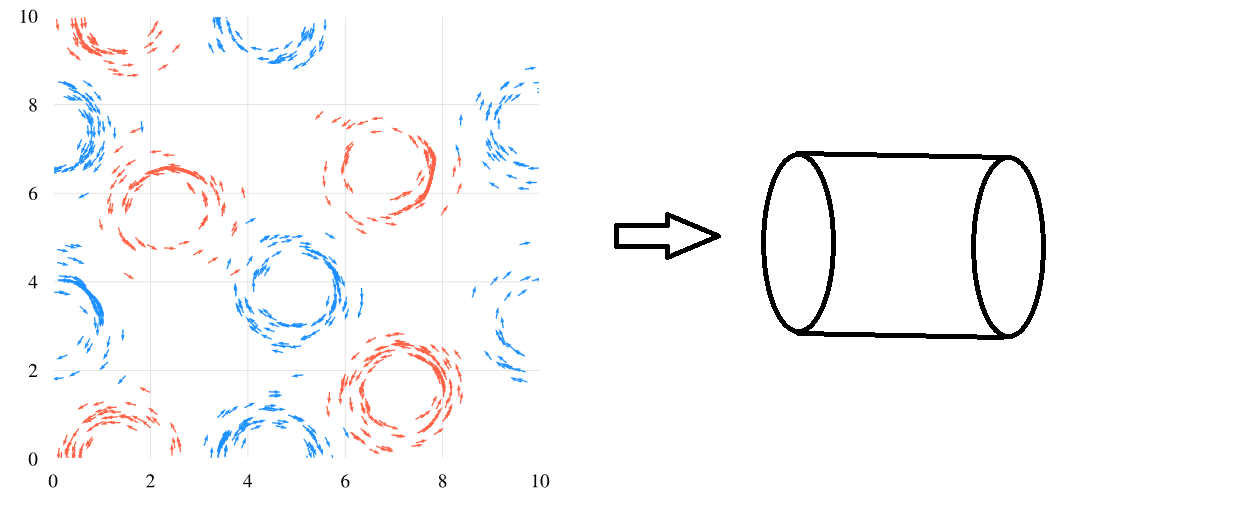

### 换元方式2

使用以下公式进行转换：
$$
\begin{aligned}
	\theta &=\frac{2\pi}{10}x\\
	\varphi &=\frac{2\pi}{10}y\\
\end{aligned}
$$

其中，$\theta$是经度（0 到 $2 \pi$），$\varphi$ 是纬度（0 到 $2 \pi$）—— 不同于传统球坐标（传统球坐标纬度非周期）。

将球坐标 ($\theta$, $\varphi$) 转换到三维笛卡尔坐标。使用以下公式进行转换：

$$
\begin{aligned}
	x' &=\left|\sin \varphi\right| \cos \theta\\
	y' &=\left|\sin \varphi\right| \sin \theta\\
	z' &=\cos \varphi\\
\end{aligned}
$$

其中，$x'$、$y'$ 和 $z'$ 是三维笛卡尔坐标。

缺点是，超过 $\pi$的纬度会与$\pi$以内的纬度重合。

### 换元方式3

将正方形区域先映射到圆形区域，再根据圆形区域的极坐标转换到球坐标。

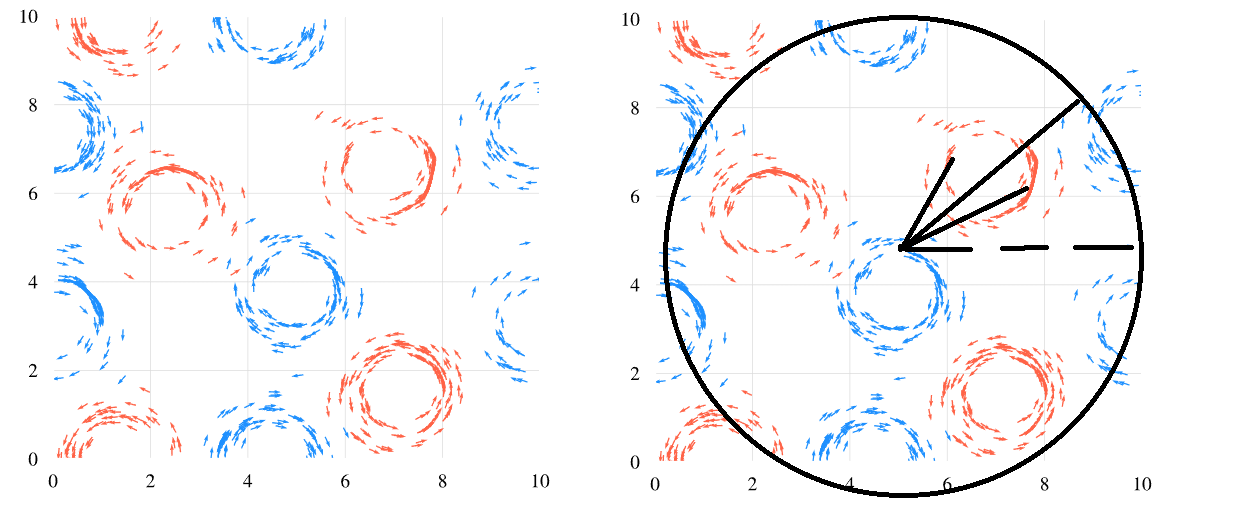

In [ ]:
fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121, projection='3d')

lastPositionX1 = totalPositionX[-1, :500]

longitudeTheta = lastPositionX1[:, 0] / 10 * 2 * np.pi
latitudePhi = lastPositionX1[:, 1] / 10 * 2 * np.pi

x1 = np.cos(longitudeTheta) * np.abs(np.sin(latitudePhi))
y1 = np.sin(longitudeTheta) * np.abs(np.sin(latitudePhi))
z1 = np.cos(latitudePhi)

ax1.scatter(x1, y1, z1, s=10, alpha=0.5)
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_title("Spatial Distribution of Agents")

pd.DataFrame(np.concatenate([x1.reshape(-1, 1), y1.reshape(-1, 1), z1.reshape(-1, 1)], axis=1)).to_csv("D:/Matlab R2020a/bin/data1.csv", index=False)

ax2 = fig.add_subplot(122, projection='3d')

lastPositionX = totalPositionX[-1, 500:]

longitudeTheta = lastPositionX[:, 0] / 10 * 2 * np.pi
latitudePhi = lastPositionX[:, 1] / 10 * 2 * np.pi

x2 = np.cos(longitudeTheta) * np.abs(np.sin(latitudePhi))
y2 = np.sin(longitudeTheta) * np.abs(np.sin(latitudePhi))
z2 = np.cos(latitudePhi)

ax2.scatter(x2, y2, z2, s=10, alpha=0.5)

pd.DataFrame(np.concatenate([x2.reshape(-1, 1), y2.reshape(-1, 1), z2.reshape(-1, 1)], axis=1)).to_csv("D:/Matlab R2020a/bin/data2.csv", index=False)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

fig = plt.figure(figsize=(13, 6))

print("omega1")
silhouetteScores = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=randomSeed).fit(np.stack([x1, y1, z1], axis=1))
    silhouette_avg = silhouette_score(np.stack([x1, y1, z1], axis=1), kmeans.labels_)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")
    silhouetteScores.append(silhouette_avg)

ax1 = fig.add_subplot(121)
ax1.plot(range(2, 10), silhouetteScores)

print("omega2")
silhouetteScores = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=randomSeed).fit(np.stack([x2, y2, z2], axis=1))
    silhouette_avg = silhouette_score(np.stack([x2, y2, z2], axis=1), kmeans.labels_)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")
    silhouetteScores.append(silhouette_avg)

ax2 = fig.add_subplot(122)
ax2.plot(range(2, 10), silhouetteScores)

In [ ]:
from sklearn.cluster import KMeans

fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121, projection='3d')
kmeans = KMeans(n_clusters=4, random_state=randomSeed).fit(np.stack([x1, y1, z1], axis=1))
labels1 = kmeans.labels_ / 4
colors = [new_cmap(i) for i in labels1]
ax1.scatter(x1, y1, z1, c=colors, s=10, alpha=0.5)
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2 = fig.add_subplot(122, projection='3d')
kmeans = KMeans(n_clusters=4, random_state=randomSeed).fit(np.stack([x2, y2, z2], axis=1))
labels2 = kmeans.labels_ / 4
colors = [new_cmap(i) for i in labels2]
ax2.scatter(x2, y2, z2, c=colors, s=10, alpha=0.5)
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_zlim(-1, 1)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

In [ ]:
lastPositionX = totalPositionX[-1, :]
lastPhaseTheta = totalPhaseTheta[-1, :]

totalLables = np.concatenate([labels1, labels2 + 1]) / 2
colors = [new_cmap(i) for i in totalLables]

fig, ax = plt.subplots(figsize=(6, 6))
ax.quiver(
    lastPositionX[:, 0], lastPositionX[:, 1],
    np.cos(lastPhaseTheta), np.sin(lastPhaseTheta), color=colors
)
ax.set_xlim(0, 10)
ax.set_xlabel(r"$x$ --> $\theta$")
ax.set_ylim(0, 10)

In [5]:
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 1.1, 0.1)
])
models = [
    SpatialGroups(strengthLambda=l, distanceD0=1, dt=0.01, tqdm=False, savePath="./data") for l in rangeLambdas
]

In [ ]:
def run_model(model):
    model.run(50000)

In [ ]:
def run_model(model):
    model.run(50000)

with Pool(19) as p:
    p.map(run_model, models)

In [34]:
model = NoAdjust(
    strengthLambda=0.5, distanceD0=np.inf, agentsNum=2, 
    tqdm=True, savePath="./data/", overWrite=True
)
model.omegaTheta = np.array([3, 3])

radius = 3 / np.abs(model.omegaTheta)

# model.phaseTheta = model.phaseTheta * 0 + np.pi / 4
positionAngle = model.phaseTheta - np.pi / 2

model.positionX[:, 0] = radius * np.cos(positionAngle) + 5
model.positionX[:, 1] = radius * np.sin(positionAngle) + 5
model.positionX[0] = model.positionX[1]
# 3 / model.omegaTheta

In [ ]:
for d0 in [0.5, 1, 1.5, 2]:
    model = NoAdjust(
        strengthLambda=3.5, distanceD0=d0, agentsNum=2, tqdm=True, savePath="./data/", overWrite=False
    )

    radius = 3 / np.abs(model.omegaTheta)

    # model.phaseTheta = model.phaseTheta * 0 + np.pi / 4
    positionAngle = model.phaseTheta + np.pi / 2
    positionAngle[:model.agentsNum // 2] = model.phaseTheta[:model.agentsNum // 2] - np.pi / 2

    model.positionX[0] = model.positionX[1]
    model.positionX[:, 0] = radius * np.cos(positionAngle) + 5
    model.positionX[:, 1] = radius * np.sin(positionAngle) + 5

    model.run(5000)

In [13]:
# same chirality
for d0 in [0.5, 1, 1.5, 2]:
    model = NoAdjust(
        strengthLambda=1, distanceD0=d0, agentsNum=2, tqdm=True, savePath="./data/", overWrite=True
    )
    model.omegaTheta = np.array([3, 3])

    radius = 3 / np.abs(model.omegaTheta)

    # model.phaseTheta = model.phaseTheta * 0 + np.pi / 4
    positionAngle = model.phaseTheta + np.pi / 2
    positionAngle[:model.agentsNum // 2] = model.phaseTheta[:model.agentsNum // 2] - np.pi / 2

    model.positionX[0] = model.positionX[1]
    model.positionX[:, 0] = radius * np.cos(positionAngle) + 5
    model.positionX[:, 1] = radius * np.sin(positionAngle) + 5

    model.run(5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [21]:
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
shift = 0
class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)
# TNum = 100

def plot_frame(i):
    if i == 0:
        return
    pbar.update(1)
    positionX = totalPositionX[i]
    phaseTheta = totalPhaseTheta[i]
    pointTheta = totalPointTheta[i]
    fig.clear()
    ax1 = plt.subplot(1, 1, 1)
    ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
    )
    ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    )
    plt.plot(totalPositionX[:i, 0, 0], totalPositionX[:i, 0, 1], color="tomato", alpha=0.5, lw=1)
    plt.plot(totalPositionX[:i, 1, 0], totalPositionX[:i, 1, 1], color='dodgerblue', alpha=0.5, lw=1)

    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    plt.legend([r"Agent 1, $\omega=3$", r"Agent 2, $\omega=3$"])

# pbar = tqdm(total=TNum)
# fig, ax = plt.subplots(figsize=(5, 5))
# ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum, 1), interval=10, repeat=False)
# ani.save(f"./mp4/{model}.mp4", dpi=200)
# pbar.close()

In [8]:
def get_ts_centers_no_mod(model):
    sa = StateAnalysis(model, classDistance=1, lookIndex=0, tqdm=False)
    ts_centers = []
    for i in range(1, sa.totalPhaseTheta.shape[0]):
        sa.lookIndex = i
        ts_centers.append(sa.centersNoMod)
    ts_centers.insert(0, ts_centers[0])
    return np.array(ts_centers)

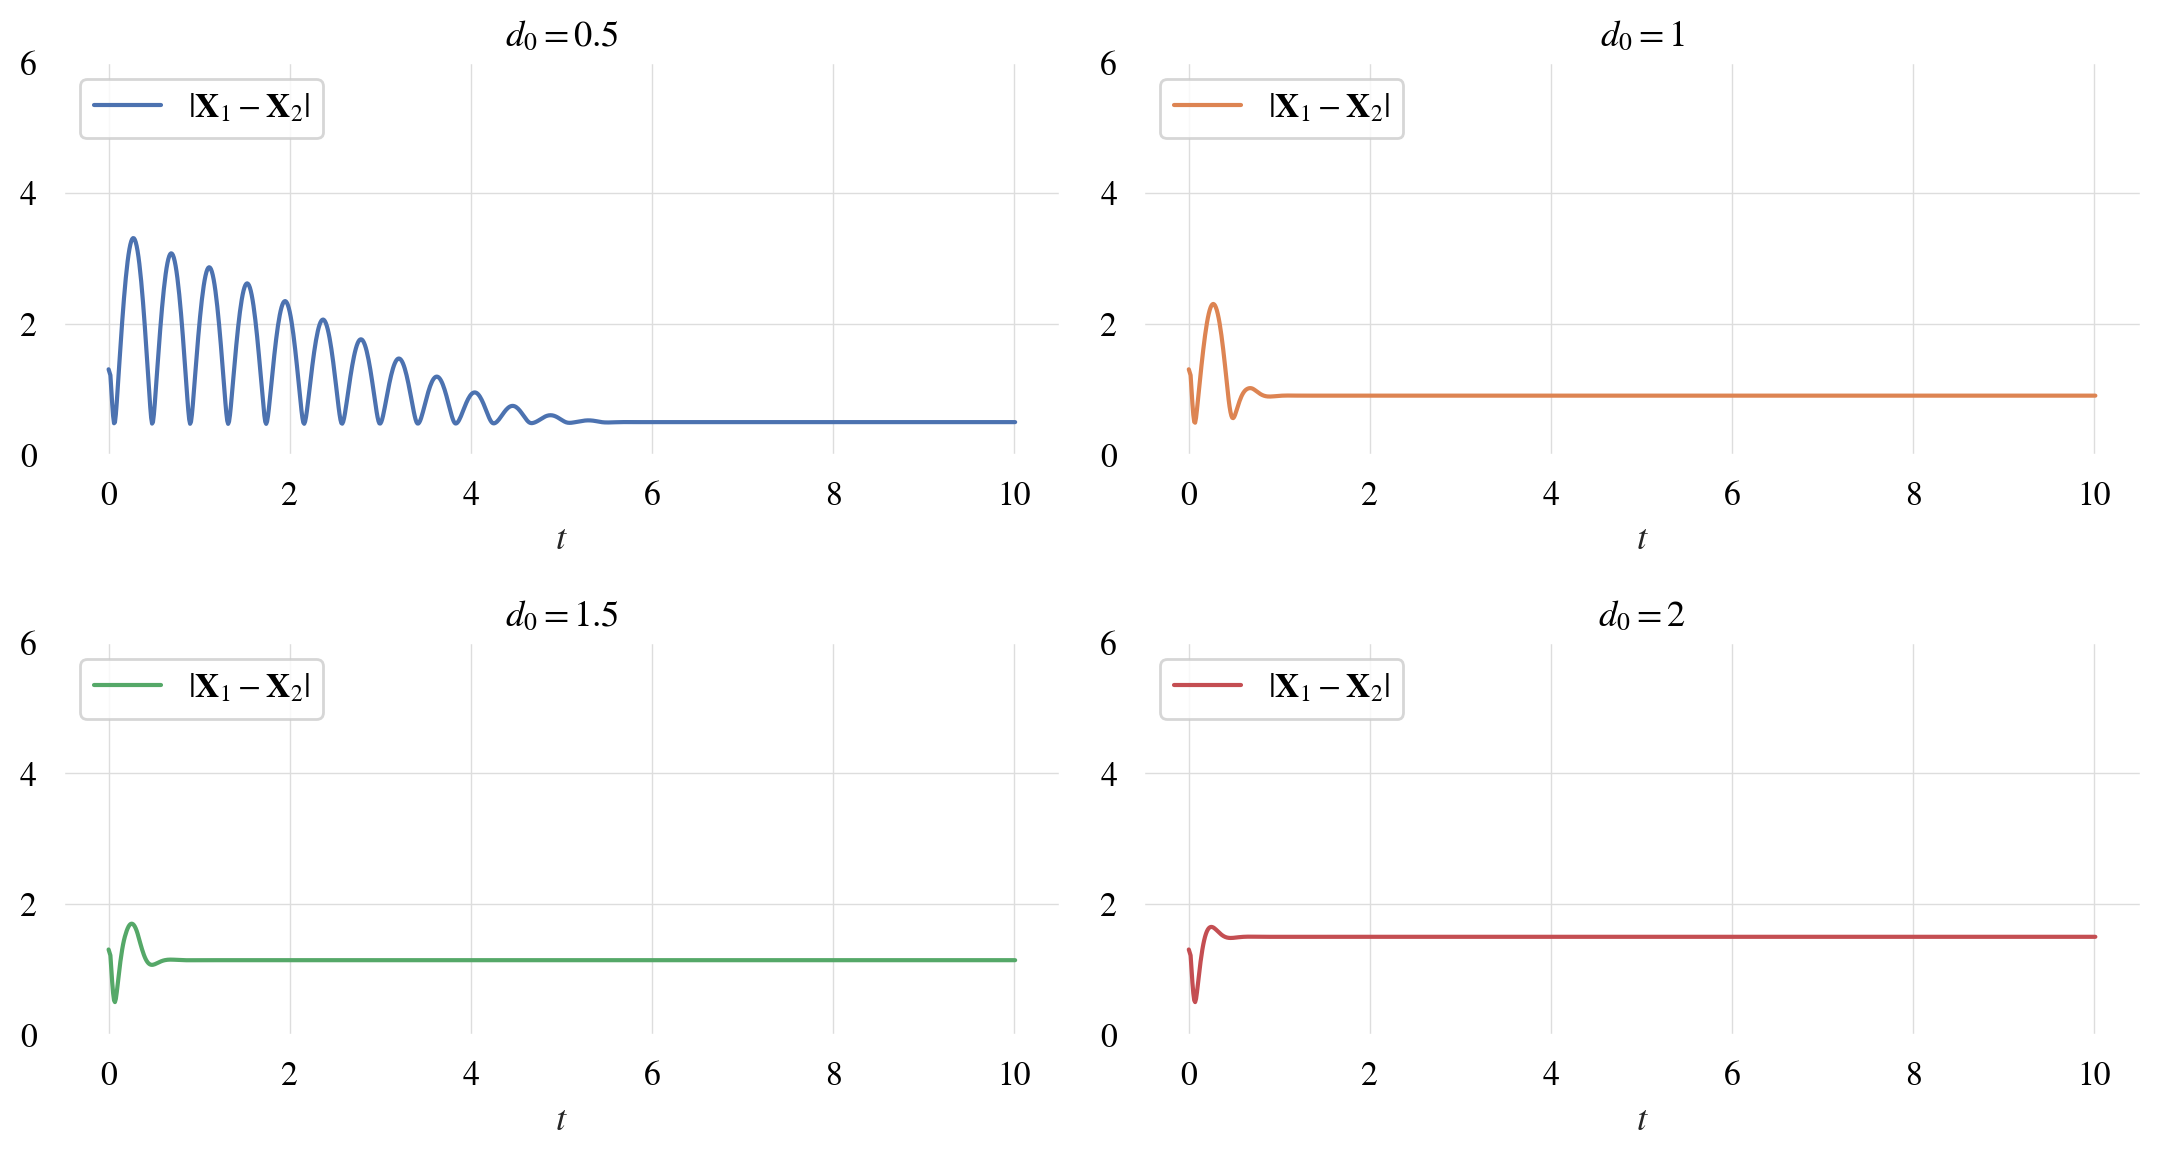

In [15]:
fig = plt.figure(figsize=(11, 6))
axs = fig.subplots(2, 2)
axsIdx = 0

for d0 in [0.5, 1, 1.5, 2]:
    model = NoAdjust(
        strengthLambda=1, distanceD0=d0, agentsNum=2, tqdm=True, savePath="./data/", overWrite=False
    )
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

    sub = totalPositionX[:, 0] - totalPositionX[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    axs[axsIdx // 2, axsIdx % 2].plot(np.arange(len(distance)) * 0.01, distance, label=r"$\left| \mathbf{X}_1-\mathbf{X}_2 \right|$", color=f"C{axsIdx}")
    axs[axsIdx // 2, axsIdx % 2].set_ylim(0, 6)
    # axs[axsIdx // 2, axsIdx % 2].axline((0, d0), slope=0, color="black", linestyle="--", label=f"$d_0$")
    axs[axsIdx // 2, axsIdx % 2].set_title(f"$d_0={d0}$")
    axs[axsIdx // 2, axsIdx % 2].set_xlabel(f"$t$")
    # r"$\left| \mathbf{X}_1-\mathbf{X}_2 \right|$"
    axs[axsIdx // 2, axsIdx % 2].legend(loc="upper left")
    axsIdx += 1

plt.tight_layout()

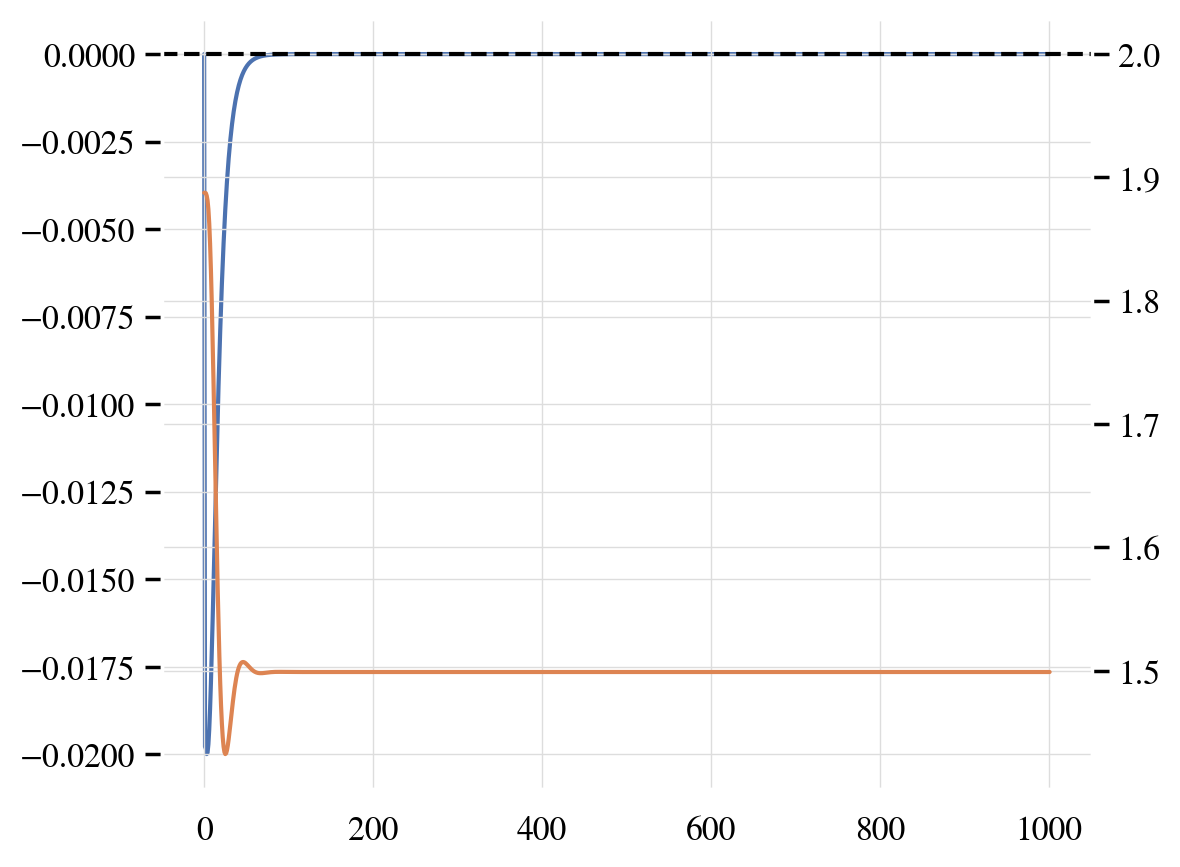

In [17]:
deltaPointTheta = totalPointTheta[:, 0] - totalPointTheta[:, 1]
plt.plot(deltaPointTheta, zorder=0)
# 副坐标轴
plt.twinx()
plt.plot(distance, color="C1")
plt.axline((0, d0), slope=0, color="black", linestyle="--", label=f"$d_0$")
# plt.scatter(np.where(distance < d0)[0], deltaPointTheta[distance < d0], s=1, zorder=1, color="red")
# plt.scatter(np.where(distance >= d0)[0], deltaPointTheta[distance >= d0], s=1, zorder=2, color="orange")

In [44]:
np.where(distance <= d0)

(array([], dtype=int64),)

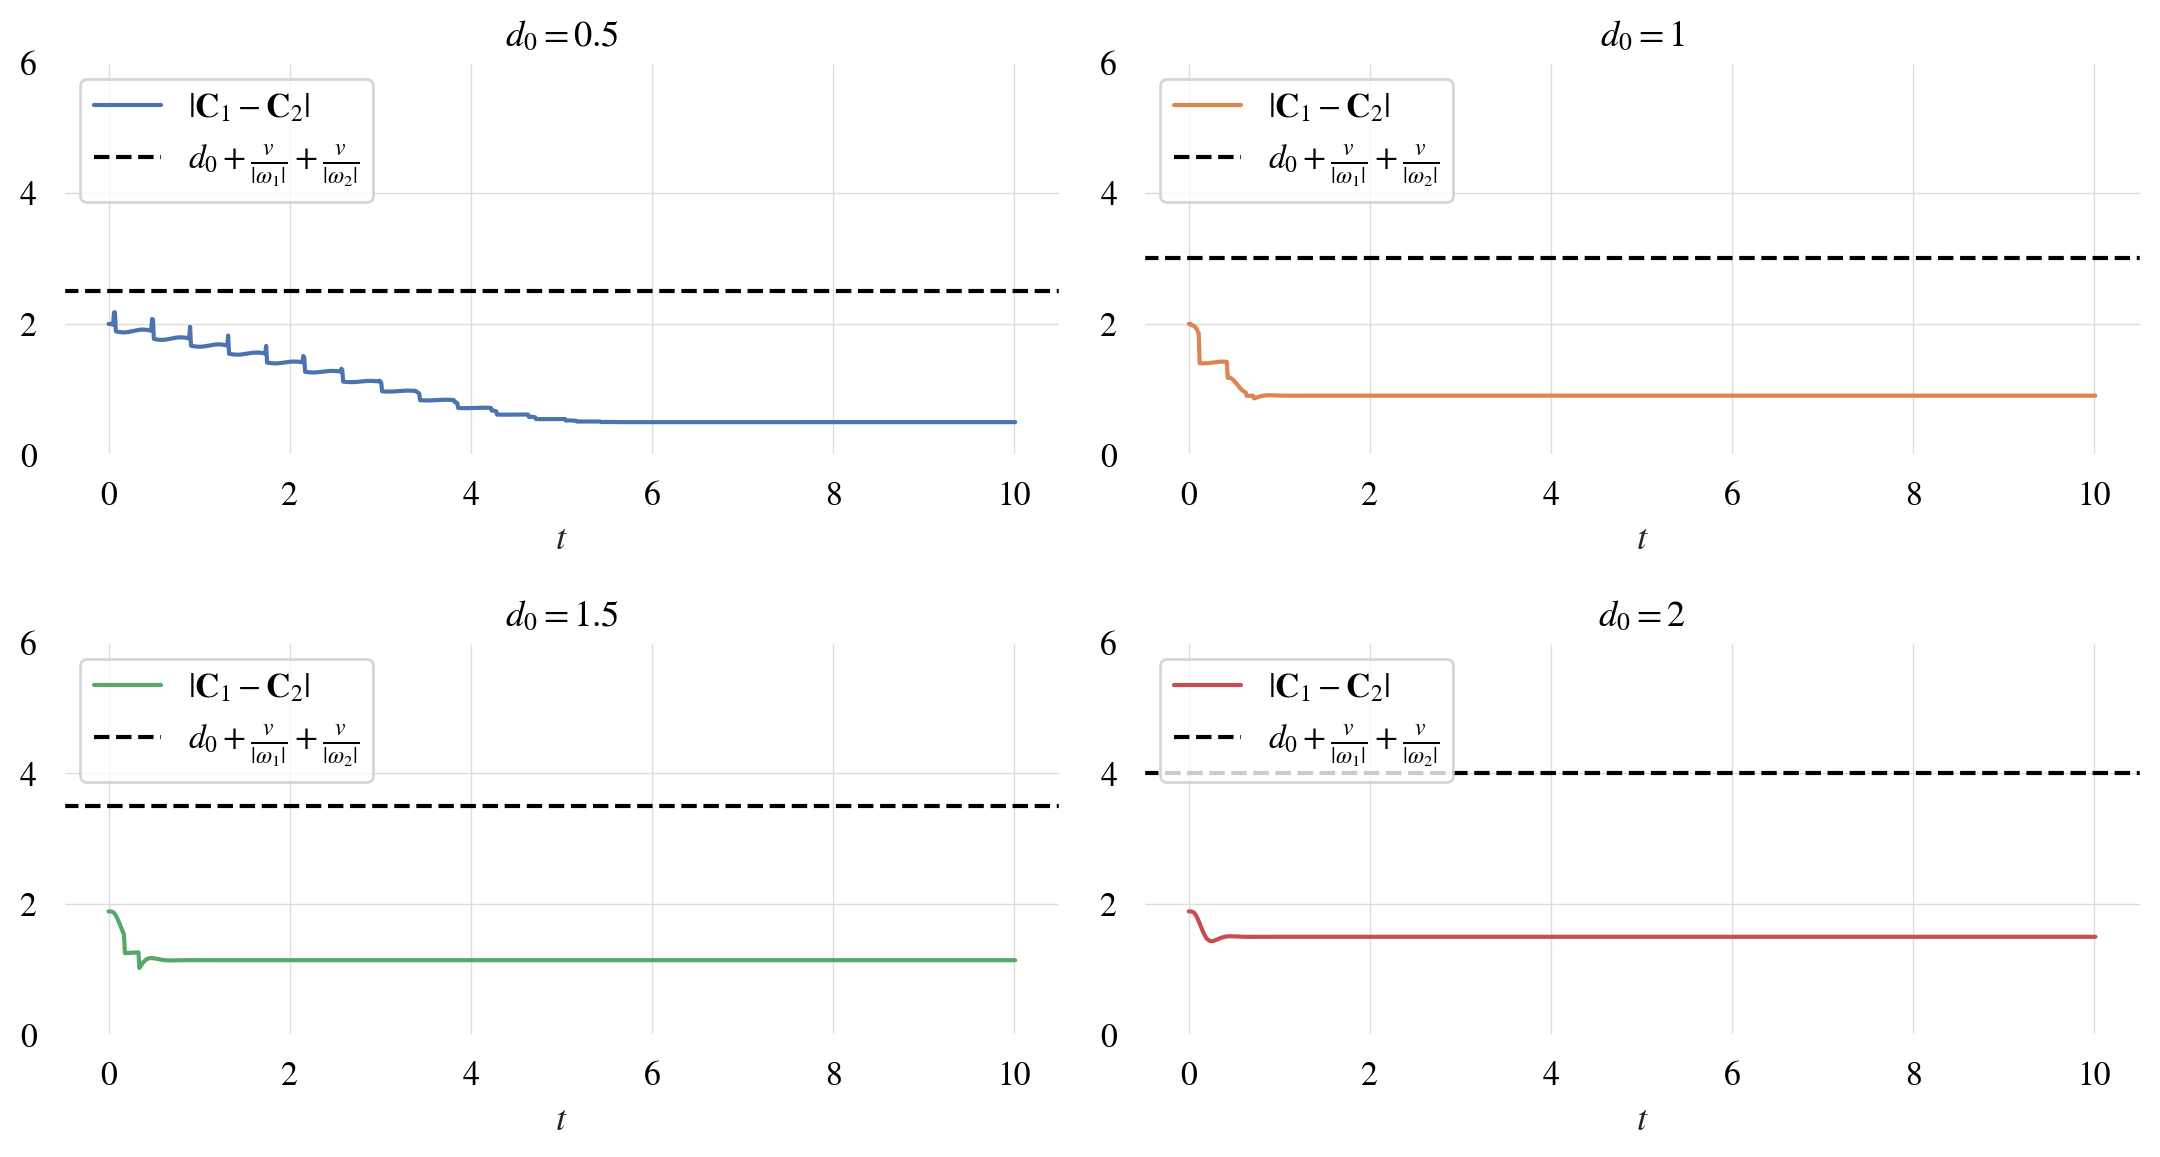

In [16]:
fig = plt.figure(figsize=(11, 6))
axs = fig.subplots(2, 2)
axsIdx = 0

for d0 in [0.5, 1, 1.5, 2]:
    model = NoAdjust(
        strengthLambda=1, distanceD0=d0, agentsNum=2, tqdm=True, savePath="./data/", overWrite=False
    )
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

    tsCentersNoMod = get_ts_centers_no_mod(model)
    sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
    # sub = totalPositionX[:, 0] - totalPositionX[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    axs[axsIdx // 2, axsIdx % 2].plot(np.arange(len(distance)) * 0.01, distance, label=r"$\left| \mathbf{C}_1-\mathbf{C}_2 \right|$", color=f"C{axsIdx}")
    axs[axsIdx // 2, axsIdx % 2].set_ylim(0, 6)
    axs[axsIdx // 2, axsIdx % 2].axline((0, d0 + np.sum(3 / np.abs(model.omegaTheta))), slope=0, color="black", linestyle="--", 
                                        label=r"$d_0+\frac{v}{\left| \omega _1 \right|}+\frac{v}{\left| \omega _2 \right|}$")
    axs[axsIdx // 2, axsIdx % 2].set_title(f"$d_0={d0}$")
    axs[axsIdx // 2, axsIdx % 2].set_xlabel(f"$t$")
    # r"$\left| \mathbf{X}_1-\mathbf{X}_2 \right|$"
    axs[axsIdx // 2, axsIdx % 2].legend(loc="upper left")
    axsIdx += 1

plt.tight_layout()

In [7]:
totalPositionX.shape

(1002, 2, 2)

(0.0, 10.0)

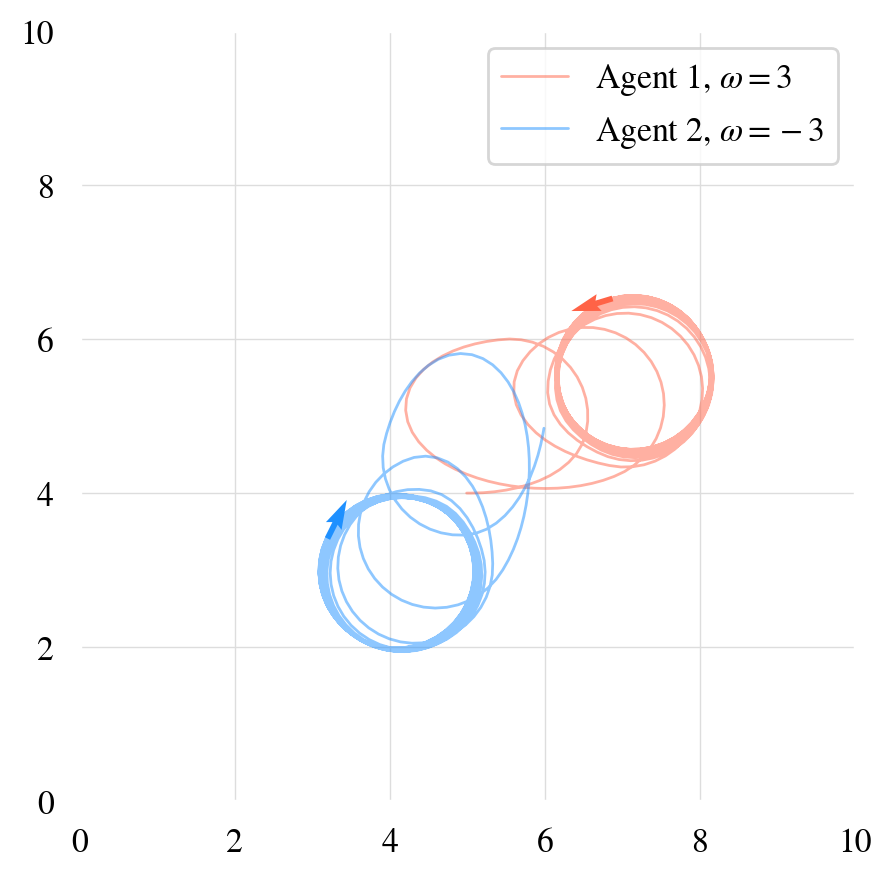

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(totalPositionX[:, 0, 0], totalPositionX[:, 0, 1], color="tomato", alpha=0.5, lw=1)
plt.plot(totalPositionX[:, 1, 0], totalPositionX[:, 1, 1], color='dodgerblue', alpha=0.5, lw=1)
plt.quiver(
    totalPositionX[-1, 0, 0], totalPositionX[-1, 0, 1],
    np.cos(totalPhaseTheta[-1, 0]), np.sin(totalPhaseTheta[-1, 0]), color="tomato", zorder=10
)
plt.quiver(
    totalPositionX[-1, 1, 0], totalPositionX[-1, 1, 1],
    np.cos(totalPhaseTheta[-1, 1]), np.sin(totalPhaseTheta[-1, 1]), color="dodgerblue", zorder=10
)
plt.legend([fr"Agent 1, $\omega={model.omegaTheta[0]}$", fr"Agent 2, $\omega={model.omegaTheta[1]}$"])

plt.xlim(0, 10)
plt.ylim(0, 10)

In [ ]:
from sympy import symbols, Function, cos, sin, Eq
from sympy.solvers.ode.systems import dsolve_system

# 定义变量和函数
t, v, omega1, omega2, lambda_ = symbols('t v omega1 omega2 lambda')
x1, y1, theta1, x2, y2, theta2 = symbols('x1 y1 theta1 x2 y2 theta2', cls=Function)

# 定义微分方程
# eq1 = Eq(x1(t).diff(t), v*cos(theta1(t)))
# eq2 = Eq(y1(t).diff(t), v*sin(theta1(t)))
eq3 = Eq(theta1(t).diff(t), omega1 + lambda_*sin(theta2(t) - theta1(t)))
# eq4 = Eq(x2(t).diff(t), v*cos(theta2(t)))
# eq5 = Eq(y2(t).diff(t), v*sin(theta2(t)))
eq6 = Eq(theta2(t).diff(t), omega2 + lambda_*sin(theta1(t) - theta2(t)))

# 解微分方程
# solution = dsolve_system([eq1, eq2, eq3, eq4, eq5, eq6])
solution = dsolve_system([eq3, eq6])

print(solution)

(0.0, 10.0)

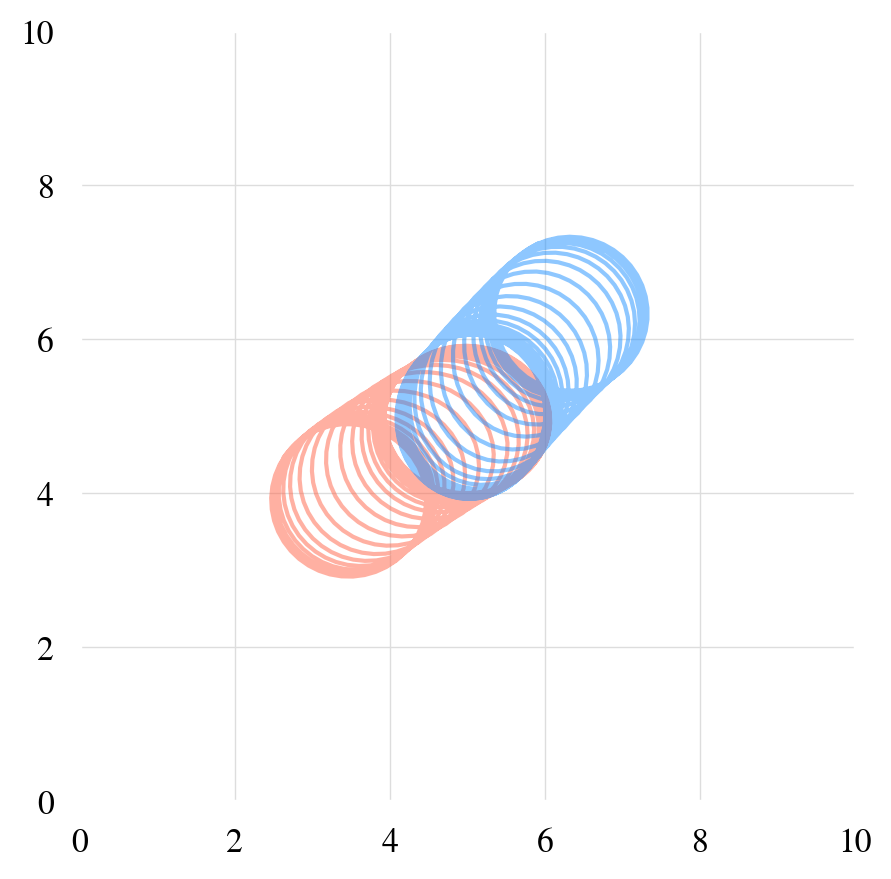

In [144]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(totalPositionX[:, 0, 0], totalPositionX[:, 0, 1], color="tomato", alpha=0.5)
plt.plot(totalPositionX[:, 1, 0], totalPositionX[:, 1, 1], color='dodgerblue', alpha=0.5)

plt.xlim(0, 10)
plt.ylim(0, 10)

  0%|          | 0/1002 [00:00<?, ?it/s]

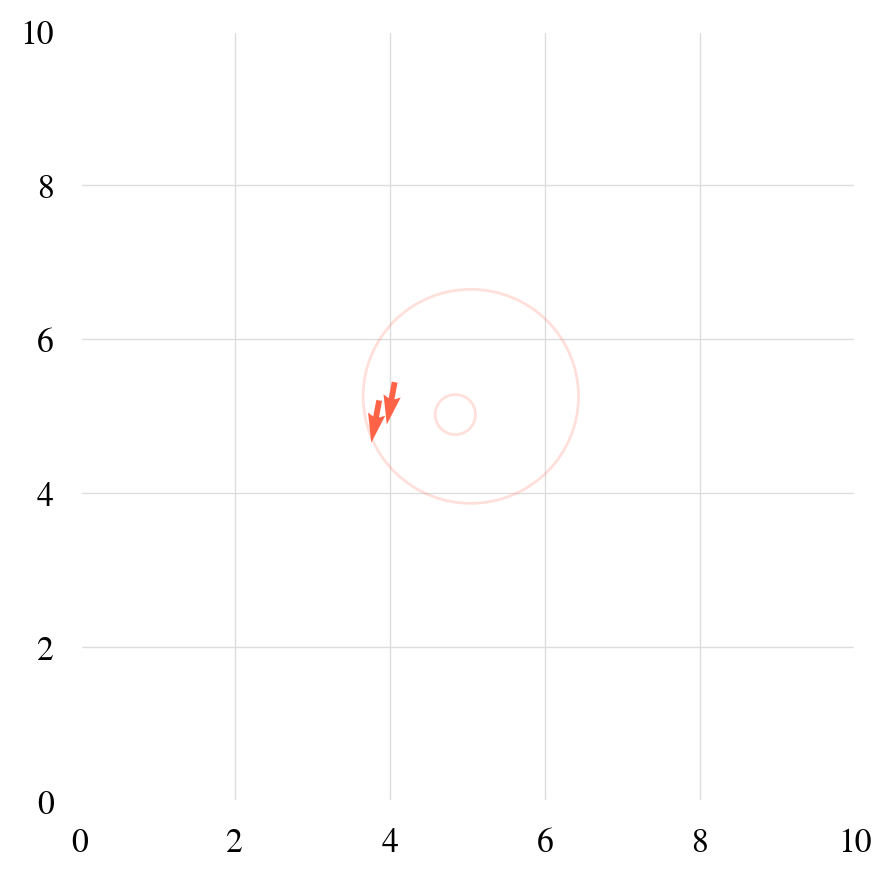

In [105]:
# Single Distribution
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
shift = 0
# TNum = 100

def plot_frame(i):
    if i == 0:
        return
    pbar.update(1)
    positionX = totalPositionX[i]
    phaseTheta = totalPhaseTheta[i]
    pointTheta = totalPointTheta[i]
    fig.clear()
    ax1 = plt.subplot(1, 1, 1)
    ax1.quiver(
        positionX[:, 0], positionX[:, 1],
        np.cos(phaseTheta[:]), np.sin(phaseTheta[:]), color='tomato'
    )
    centers = StateAnalysis._calc_centers(positionX, phaseTheta, pointTheta, model.speedV)
    radius = np.sqrt(np.sum((positionX - centers) ** 2, axis=0))
    ax1.add_artist(plt.Circle(centers[0], radius[0], fill=False, color='tomato', alpha=0.2))
    ax1.add_artist(plt.Circle(centers[1], radius[1], fill=False, color='tomato', alpha=0.2))

    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

pbar = tqdm(total=TNum)
fig, ax = plt.subplots(figsize=(5, 5))
ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum, 1), interval=10, repeat=False)
ani.save(f"./mp4/{model}.mp4", dpi=200)
pbar.close()